In [3]:
from google.colab import drive
from tqdm.auto import tqdm
import pprint
import torch
import os

drive.mount('/content/drive')
os.chdir("drive/MyDrive/____huggingface/__BERTino")
pprint = pprint.PrettyPrinter(indent=4).pprint
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

In [ ]:
%%capture
# Remember to restart the kernel!
!pip install tokenizers
!pip install transformers
!pip install mlflow

# Data pre-processing

First of all we have to perform some adjustment on the dataset as it is. We can notice that the labels are encoded in three different columns with their respective probability. Since we are insterted in performing a multi-class classification we have to gather them into one single column.

To do this we extract the tree columns in which we are instered *["NEG",	"NEU",	"POS"]*, we transform them into numpy array and lastly we take the index of the maximum for each row.

In [5]:
import pandas as pd

raw_classification = pd.read_csv('data/raw_classification.tsv', sep="\t")
raw_classification.rename(columns={'TWID':'id'}, inplace=True)

tweets = pd.read_csv('data/raw_tweets_text.csv')
raw_df = pd.merge(raw_classification, tweets, on='id')
raw_df.head(2)

,id,NEG,NEU,POS,text
0,768096868504969216,0.049398,0.861395,0.089207,#Incredible #India #Atulya #Bharat - Land of S...
1,768097237620490241,0.028733,0.929554,0.041713,RT @AlwaysTrustKay: Are you near a Western uni...


In [6]:
raw_val = raw_df.loc[:, ['NEG', 'NEU','POS']].values
sentiment = torch.argmax(torch.tensor(raw_val), dim=1).tolist()

raw_df['sentiment'] = sentiment
raw_df.drop(columns=["NEG",	"NEU",	"POS"], inplace=True)

# to have an idea of what is going on.
raw_val[0:5], sentiment[0:5]

(array([[0.04939849, 0.86139469, 0.08920682],
        [0.028733  , 0.92955397, 0.04171303],
        [0.0065981 , 0.04681042, 0.94659148],
        [0.03233298, 0.85094479, 0.11672223],
        [0.0080897 , 0.04233099, 0.9495793 ]]),
 [1, 1, 2, 1, 2])

## Train-Test split

Now that we have transformer our three columns into one we are able to split our dataset into a train df and a test df. We do this operation using the *train_test_split* function from sklearn. We also specify to stratify the two datasets so that they will have the same distribution of the target variable in both the sets.

In [7]:
from sklearn.model_selection import train_test_split

X, sentiment = raw_df.text, raw_df.sentiment
X_train, X_test, y_train, y_test = train_test_split(X.values, 
                                                    sentiment.values, 
                                                    test_size=.2, 
                                                    stratify=sentiment.values, 
                                                    random_state=42)

# lastly we save them.
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})
test_df = pd.DataFrame({'text': X_test, 'sentiment': y_test})
train_df.to_csv('data/train.csv',index=False, sep=",")
test_df.to_csv('data/test.csv',index=False, sep=",")

sent_mapping = {'neg':0, 'neu':1, 'pos':2}
print("train_test_split", len(train_df), len(test_df))

train_test_split 943965 235992


We check the distribution of the target variable in both the datasets.

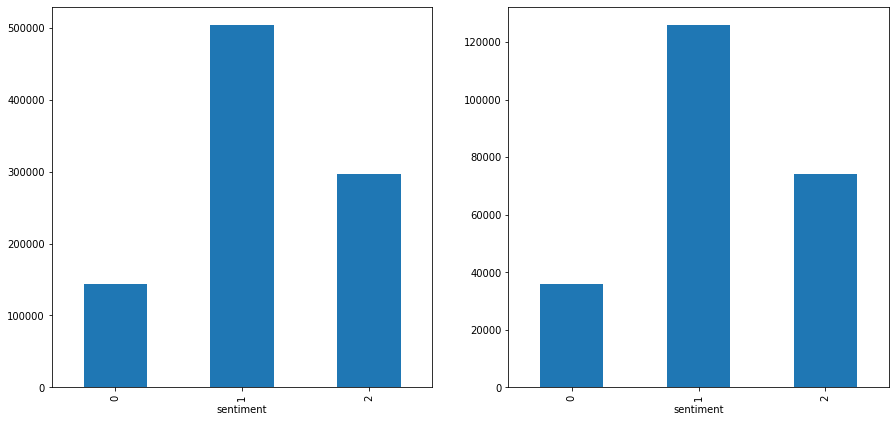

In [ ]:
import matplotlib.pyplot as plt

fig,axes= plt.subplots(1,2, figsize=(15,7))
train_df.groupby(['sentiment']).size().plot.bar(ax=axes[0])
test_df.groupby(['sentiment']).size().plot.bar(ax=axes[1])

plt.show()

# DistilBert Model

We create now an instance of the DistilBert model. We are performing a classification operation so we can also directly used a DistiBertForSequenceClassification but in this case we preferred create our own torch class and reproduce it following the docs of DistilBert.

We inherite the *PreTrainedModel* class from huggingface so that we will be able to save and load the model then in an easier way. We pass the configuration downloaded directly from the huggingface hub.

We add the 3 layers, a dense layer with a Relu activation, a dropout and a last dense layer that has an output of 3 as the number of classes that we are trying to predict. The structure is the same as in the docs, as well with the forward method. i just want to point out that:

```py
distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
```

has the parameter return_dict=False.


In [8]:
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoModel, AutoTokenizer, PreTrainedModel, PretrainedConfig)
from sklearn import metrics
from tqdm.auto import tqdm
from torch import nn
import numpy as np
import mlflow
import re


class DistilBertTweet(PreTrainedModel):
    def __init__(self, name='bertino_tweet', dropout=0.2):
        super().__init__(config=PretrainedConfig.from_json_file('./model/model_config.json'))
        self.name = name

        self.distilbert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = nn.Linear(768, 768)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]

        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = self.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.classifier(pooled_output)

        return pooled_output

We can have a look at the structure of the model that we are creating:

In [10]:
DistilBertTweet()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertTweet(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

# Torch Dataset and DataLoader

We create now our actual dataset and dataloader using the torch classes.
we recall that torch class Dataset stores the samples and their corresponding labels, while DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

each dataset must have the __len__ properties and the __getitem__ properties well defined. in our case we decide to tokenize the sentence while are feeded to the model. Doing this basically when we iterate over the dataset the elements will be first cleaned up and then tokenized.

We used some regex to clean up such as removing all the words that starts with @ (for instance the tag as @myself), removed all the words starting with http and others. 

then we create the tokens as follow:

```py
        inputs = self._tokenizer.encode_plus(
            comment_text,
            # None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=False,
        )
```

Where max_length we remember that for BERT and similar must be less than 512, the return_token_type_ids in our case is useless since it represent the number of the sentece (BERT was trained also to understand if two sentences could be attacched, in that case the first sentece had token_type_ids = 0 while the second = 1, since we are not reproducing this kind of training we just remove it). We allow truncation so in case there are some sentences that have more that max_length tokens they will be truncated and we specify the padding techniques, in this case to the maximum_length.

We also create a simple function that create the dataset and the dataloader according to the batch_size argument passed. 

In [11]:
class CustomDataset(Dataset):
    sent_mapping = {'neg':0, 'neu':1, 'pos':2}
    def __init__(self, dataframe, tokenizer, max_len=140):
        self._tokenizer = tokenizer
        self.text = dataframe.text
        self.targets = dataframe.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.targets)

    @property
    def tokenizer(self):
      return self._tokenizer

    @property
    def get_labels(self):
      return self.labels

    def pre_process_text(self,row):
      row = re.sub(r'@\S+|http\S*|\!|\?|#|RT+|\d+|\.*|\,*|\-*|@|\[|\]|\(|\)|\:|\;|\+|\*|\-|\_|\"', '', row).strip()
      row = row.lower()
      return row

    def __getitem__(self, index):
        comment_text = self.text[index]
        comment_text = self.pre_process_text(comment_text)
        
        inputs = self._tokenizer.encode_plus(
            comment_text,
            # None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=False,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return ({
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.float)
                })
      


def create_dataset(train_raw, test_raw, tokenizer, tokenizer_lenght, BATCH_SIZE):
  training_set = CustomDataset(train_raw, tokenizer, tokenizer_lenght)
  eval_set = CustomDataset(test_raw, tokenizer, tokenizer_lenght)
  return (DataLoader(training_set, batch_size= BATCH_SIZE, shuffle=True), DataLoader(eval_set, batch_size= BATCH_SIZE, shuffle=True))

we can test it out to understand how it behave

In [12]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)
train, test = create_dataset(train_df, test_df, tokenizer, 10, 8)

for idx, val in enumerate(train):
  print(val['ids'], tokenizer.decode(val['ids'][0]))
  break

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 9.32kB/s]
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 621kB/s] 
Downloading: 100%|██████████| 455k/455k [00:00<00:00, 713kB/s] 


tensor([[  101, 28939,  2106,  1057,  2298,  1999, 24471,  5789,  4524,   102],
        [  101,  3696,  2039,  2000,  6951,  2012, 23217,  2414,  2024,   102],
        [  101,  4086,  1055,  3630,  6559,  8301,  4246, 15509,  5645,   102],
        [  101,  2023,  2003,  1037,  9984,  1005,  1055,  3145,  3614,   102],
        [  101,   100,  2021,  1045,  2123,  1005,  1056,  2031,  2026,   102],
        [  101,  4742,  5485,  2128, 15532,  1999,  8586,  4487, 24137,   102],
        [  101,  3422, 11690,  3185, 23601,  2063,  2007, 11660,  4147,   102],
        [  101,  2572,  9541,  2953,  2003,  2085,  2206,  2033,  2006,   102]]) [CLS] bf did u look in ur makeup bag [SEP]


# Trainer

Now we create our trainer class wich will handle the training process of our model. We largely used MLFLOW to log our parameters and metrics. MLFLOW is a free open-source platform that allow to handle end-end machine learning experiments. 

this is an example of metrics tracking provided freely by mlflow and databricks

In [13]:
from sklearn.metrics import classification_report, accuracy_score

class Trainer:
  def __init__(self, model, loss_fn, epoch, path, optimizer, scheduler):
    self.model = model
    self.loss_fn = loss_fn
    self.epochs = epoch 
    self.optimizer = optimizer
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
    self.scheduler = scheduler
    self.path = path

  def training_loop(self, training_loader, testing_loader, run_name, **kwargs):
    self.model.to(self.device)
    with mlflow.start_run(run_name=run_name) as run:  
      for key, value in kwargs.items():
        mlflow.log_param(key, value)
      self.train(training_loader, testing_loader)
      mlflow.pytorch.log_model(self.model, self.model.name)

  def handle_metrics_multiclass(self, metrics, output, truth):
    accuracy = accuracy_score(output.cpu(), truth.cpu())
    batch_metric = classification_report(output.cpu(), truth.cpu(), 
                                         target_names=['neg','neu','pos'],
                                         labels=[0, 1, 2], 
                                         output_dict=True, zero_division=0)
    metrics['accuracy'] += accuracy
    metrics['macro avg']["f1-score"] += batch_metric['macro avg']["f1-score"]
    metrics['macro avg']["precision"] += batch_metric['macro avg']["precision"]
    metrics['neg']["precision"] += batch_metric['neg']["precision"]
    metrics['neg']["f1-score"] += batch_metric['neg']["f1-score"]
    metrics['neg']["recall"] += batch_metric['neg']["recall"]
    metrics['neu']["precision"] += batch_metric['neu']["precision"]
    metrics['neu']["f1-score"] += batch_metric['neu']["f1-score"]
    metrics['neu']["recall"] += batch_metric['neu']["recall"]
    metrics['pos']["precision"] += batch_metric['pos']["precision"]
    metrics['pos']["f1-score"] += batch_metric['pos']["f1-score"]
    metrics['pos']["recall"] += batch_metric['pos']["recall"]

    metrics['step'] += 1

  
  def log_multiple_metrics(self, metrics, step, prefix='train'):
      for key, value in metrics.items():
        if key != 'step':
          if type(value) == dict:
            for key_inside, value_inside in metrics[key].items():
              mlflow.log_metric(f"{prefix}_{key}_{key_inside}", (value_inside/metrics['step']), step=step)
          elif key == 'loss':
           mlflow.log_metric(f"{prefix}_{key}", (value), step=step)
          else:
           mlflow.log_metric(f"{prefix}_{key}", (value/metrics['step']), step=step)

      
  def train(self, training_loader, testing_loader):
        step = 0
        for epoch in (range(self.epochs)):
          self.model.train()

          metrics_train = {
              "step":0, "accuracy":0, 
              "macro avg": {"f1-score":0, "precision":0},
              "neg": {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0},
              "neu": {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0},
              "pos": {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0}}

          total, correct = 0,0
          for idx, data in tqdm(enumerate(training_loader), total=len(training_loader)):
              ids = data['ids'].to(self.device, dtype = torch.long)
              mask = data['mask'].to(self.device, dtype = torch.long)
              targets = data['targets'].to(self.device, dtype = torch.long)

              outputs = self.model(ids, mask) 
              self.optimizer.zero_grad()
              loss = self.loss_fn(outputs, targets)

              _, predicted = torch.max(outputs.data, 1)
              total += targets.size(0)
              correct += (predicted == targets).sum().item()

              self.handle_metrics_multiclass(metrics_train, predicted, targets)

              if idx%1000 == 0:
                  metrics_train['loss'] = loss.item()
                  self.log_multiple_metrics(metrics_train, step=step, prefix='train')
                  step += 1

              if idx % 20_000 == 0 and idx != 0:
                self.scheduler.step()

              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()

          train_accuracy = correct/total
          mlflow.log_metric("train accuracy__",train_accuracy, step=epoch)

          self.log_multiple_metrics(metrics_train, step=step, prefix='train')
          self.validation(testing_loader, epoch)
        

  def validation(self, testing_loader, epoch):
    self.model.eval()

    metrics_test = {
    "step":0, "accuracy":0, 
    "macro avg": {"f1-score":0, "precision":0},
    "neg": {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0},
    "neu": {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0},
    "pos": {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0}}
    
    total, correct = 0,0
    with torch.no_grad():
        for idx, data in tqdm(enumerate(testing_loader), total=len(testing_loader)):
            ids = data['ids'].to(self.device, dtype = torch.long)
            mask = data['mask'].to(self.device, dtype = torch.long)
            targets = data['targets'].to(self.device, dtype = torch.long)

            outputs = self.model(ids, mask) 

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()  

            self.handle_metrics_multiclass(metrics_test, predicted, targets)

    mlflow.log_metric("test accuracy__", correct/total, step=epoch)

    self.log_multiple_metrics(metrics_test, step=epoch, prefix='test')

    torch.save(self.model, f"{self.path}{self.model.name}.pt")

    torch.save({"optimizer": self.optimizer.state_dict(), 
                "scheduler": self.scheduler.state_dict(), "epoch": epoch}, 
                f"{self.path}{self.model.name}-re_train_args.pt")

def print_details(model, params):
    print("-"*150)
    print(model)
    print("-"*150)
    for layer in params['trainable_layers']:
      print(f"Layer to train --> {layer}")
    print("-"*150)
    pprint(params)
    print("-"*150)

# Wrap Up
Now we bring all together and we can train the model.

If you want to keep track of the experiment online you can register to [databricks community](https://docs.databricks.com/applications/mlflow/tracking.html) edition and pass your credentials. otherwhise you can just comment those lines. 

Before training the Model we freeze all the layers that come directly from the encoder. We want to train only the last classification layer. we perform this operation by setting *requires_grad* equal to false for all the layer that cointains 'bert' inside the name. 

In [14]:
train = True

if train:
  !databricks configure --host https://community.cloud.databricks.com/
  mlflow.set_tracking_uri('databricks')
  mlflow.set_experiment("/Users/gabriele.ghisleni01@gmail.com/Bertino_Tweets")

  PARAMS = {"epochs":4, "lr":1e-04, "batch_size":16, "model_name": 'eng_distilber', 'gamma':0.96,
            "tokenizer_max_lenght":25, 'trainable_layers':[], "train-test": (len(train_df), len(test_df))}

  tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)
  training_loader, testing_loader = create_dataset(train_df, test_df, tokenizer, PARAMS['tokenizer_max_lenght'], PARAMS['batch_size'])

  model = DistilBertTweet(name=PARAMS['model_name'])
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=PARAMS['lr'])
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=PARAMS['gamma'])

  # model = torch.load('./model/bert_simple.pt')
  # optimizer.load_state_dict(torch.load('./model/bert_simple-optimizer.pt'))
  
  for name, param in model.named_parameters():
    if "bert" in name: param.requires_grad = False
    if param.requires_grad:
      PARAMS['trainable_layers'].append(name)
  
  print_details(model, PARAMS)
  trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, epoch=PARAMS['epochs'],  path='./model/')
  trainer.training_loop(training_loader, testing_loader, run_name=PARAMS['model_name'], **PARAMS)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------------------------------------------------------------------------------------------------------------------------------------------
DistilBertTweet(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): Layer